In [44]:
import numpy as np
import pandas as pd
from pydataset import data
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures


In [2]:
swiss = data('swiss')

In [3]:
swiss.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, Courtelary to Rive Gauche
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fertility         47 non-null     float64
 1   Agriculture       47 non-null     float64
 2   Examination       47 non-null     int64  
 3   Education         47 non-null     int64  
 4   Catholic          47 non-null     float64
 5   Infant.Mortality  47 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 2.6+ KB


In [10]:
swiss['Infant_Mortality'] = swiss['Infant.Mortality']

In [15]:
swiss.drop('Infant.Mortality', inplace=True, axis=1)

In [23]:
def train_validate_test(df, target):
    '''
    this function takes in a dataframe and splits it into 3 samples, 
    a test, which is 20% of the entire dataframe, 
    a validate, which is 24% of the entire dataframe,
    and a train, which is 56% of the entire dataframe. 
    It then splits each of the 3 samples into a dataframe with independent variables
    and a series with the dependent, or target variable. 
    The function returns 3 dataframes and 3 series:
    X_train (df) & y_train (series), X_validate & y_validate, X_test & y_test. 
    '''
    # split df into test (20%) and train_validate (80%)
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)

    # split train_validate off into train (70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

        
    # split train into X (dataframe, drop target) & y (series, keep target only)
    X_train = train.drop(columns=[target])
    y_train = train[target]
    
    # split validate into X (dataframe, drop target) & y (series, keep target only)
    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]
    
    # split test into X (dataframe, drop target) & y (series, keep target only)
    X_test = test.drop(columns=[target])
    y_test = test[target]
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [25]:
X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(swiss, 'Infant_Mortality')

In [77]:
X_test

,Fertility,Agriculture,Examination,Education,Catholic
Gruyere,82.4,53.3,12,7,97.67
Aigle,64.1,62.0,21,12,8.52
V. De Geneve,35.0,1.2,37,53,42.34
La Vallee,54.3,15.2,31,20,2.15
ValdeTravers,67.6,18.7,25,7,8.65
Entremont,69.3,84.9,7,6,99.68
Val de Ruz,77.6,37.6,15,7,4.97
Veveyse,87.1,64.5,14,6,98.61
Porrentruy,76.1,35.3,9,7,90.57
Delemont,83.1,45.1,6,9,84.84


In [27]:
X_train

,Fertility,Agriculture,Examination,Education,Catholic
Rolle,60.5,60.8,16,10,7.72
Lavaux,65.1,73.0,19,9,2.84
Nyone,56.6,50.9,22,12,15.14
Conthey,75.5,85.9,3,2,99.71
Yverdon,65.4,49.5,15,8,6.10
Oron,72.5,71.2,12,1,2.40
Cossonay,61.7,69.3,22,5,2.82
St Maurice,65.0,75.9,9,9,99.06
Franches-Mnt,92.5,39.7,5,5,93.40
Orbe,57.4,54.1,20,6,4.20


In [30]:
def get_object_cols(df):
    '''
    This function takes in a dataframe and identifies the columns that are object types
    and returns a list of those column names. 
    '''
    # create a mask of columns whether they are object type or not
    mask = np.array(df.dtypes == "object")

        
    # get a list of the column names that are objects (from the mask)
    object_cols = df.iloc[:, mask].columns.tolist()
    
    return object_cols

In [31]:
object_cols = get_object_cols(swiss)

In [32]:
def get_numeric_X_cols(X_train, object_cols):
    '''
    takes in a dataframe and list of object column names
    and returns a list of all other columns names, the non-objects. 
    '''
    numeric_cols = [col for col in X_train.columns.values if col not in object_cols]
    
    return numeric_cols

In [33]:
numeric_cols = get_numeric_X_cols(X_train, object_cols)

In [34]:
def min_max_scale(X_train, X_validate, X_test, numeric_cols):
    '''
    this function takes in 3 dataframes with the same columns, 
    a list of numeric column names (because the scaler can only work with numeric columns),
    and fits a min-max scaler to the first dataframe and transforms all
    3 dataframes using that scaler. 
    it returns 3 dataframes with the same column names and scaled values. 
    '''
    # create the scaler object and fit it to X_train (i.e. identify min and max)
    # if copy = false, inplace row normalization happens and avoids a copy (if the input is already a numpy array).


    scaler = MinMaxScaler(copy=True).fit(X_train[numeric_cols])

    #scale X_train, X_validate, X_test using the mins and maxes stored in the scaler derived from X_train. 
    # 
    X_train_scaled_array = scaler.transform(X_train[numeric_cols])
    X_validate_scaled_array = scaler.transform(X_validate[numeric_cols])
    X_test_scaled_array = scaler.transform(X_test[numeric_cols])

    # convert arrays to dataframes
    X_train_scaled = pd.DataFrame(X_train_scaled_array, 
                                  columns=numeric_cols).\
                                  set_index([X_train.index.values])

    X_validate_scaled = pd.DataFrame(X_validate_scaled_array, 
                                     columns=numeric_cols).\
                                     set_index([X_validate.index.values])

    X_test_scaled = pd.DataFrame(X_test_scaled_array, 
                                 columns=numeric_cols).\
                                 set_index([X_test.index.values])

    
    return X_train_scaled, X_validate_scaled, X_test_scaled

In [37]:
X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scale(X_train, X_validate, X_test, numeric_cols)

In [42]:
y_train.head()

Rolle      16.3
Lavaux     20.0
Nyone      16.7
Conthey    15.1
Yverdon    22.5
Name: Infant_Mortality, dtype: float64

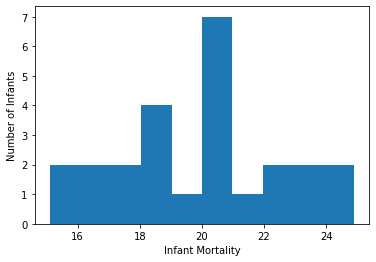

In [41]:
plt.hist(y_train)
plt.xlabel("Infant Mortality")
plt.ylabel("Number of Infants")
plt.show()

In [46]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict IM_pred_mean
IM_pred_mean = y_train['Infant_Mortality'].mean()
y_train['IM_pred_mean'] = IM_pred_mean
y_validate['IM_pred_mean'] = IM_pred_mean

# 2. compute IM_pred_median
IM_pred_median = y_train['Infant_Mortality'].median()
y_train['IM_pred_median'] = IM_pred_median
y_validate['IM_pred_median'] = IM_pred_median

# 3. RMSE of IM_pred_mean
rmse_train = mean_squared_error(y_train.Infant_Mortality, y_train.IM_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.Infant_Mortality, y_validate.IM_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of IM_pred_median
rmse_train = mean_squared_error(y_train.Infant_Mortality, y_train.IM_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.Infant_Mortality, y_validate.IM_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  2.61 
Validate/Out-of-Sample:  2.03
RMSE using Median
Train/In-Sample:  2.61 
Validate/Out-of-Sample:  2.02


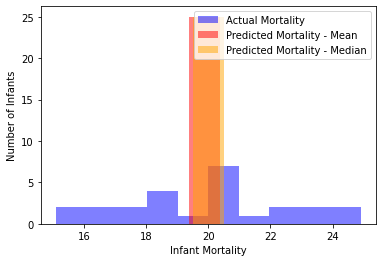

In [47]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.Infant_Mortality, color='blue', alpha=.5, label="Actual Mortality")
plt.hist(y_train.IM_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Mortality - Mean")
plt.hist(y_train.IM_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Mortality - Median")
plt.xlabel("Infant Mortality")
plt.ylabel("Number of Infants")
plt.legend()
plt.show()

## LinearRegression (OLS)

In [49]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.Infant_Mortality)

# predict train
y_train['IM_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Infant_Mortality, y_train.IM_pred_lm)**(1/2)

# predict validate
y_validate['IM_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Infant_Mortality, y_validate.IM_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  1.665747147276798 
Validation/Out-of-Sample:  3.2457238104762527


## LassoLars

In [50]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.Infant_Mortality)

# predict train
y_train['IM_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Infant_Mortality, y_train.IM_pred_lars)**(1/2)

# predict validate
y_validate['IM_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Infant_Mortality, y_validate.IM_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  2.6100850560853375 
Validation/Out-of-Sample:  2.0288147607244316


## TweedieRegressor (GLM)

In [51]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.Infant_Mortality)

# predict train
y_train['IM_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Infant_Mortality, y_train.IM_pred_glm)**(1/2)

# predict validate
y_validate['IM_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Infant_Mortality, y_validate.IM_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)



RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  1.6657359263315208 
Validation/Out-of-Sample:  3.064275296769998


## Polynomial Regression

In [53]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [54]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.Infant_Mortality)

# predict train
y_train['IM_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Infant_Mortality, y_train.IM_pred_lm2)**(1/2)

# predict validate
y_validate['IM_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Infant_Mortality, y_validate.IM_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  1.1216642719534893 
Validation/Out-of-Sample:  4.027784473994384


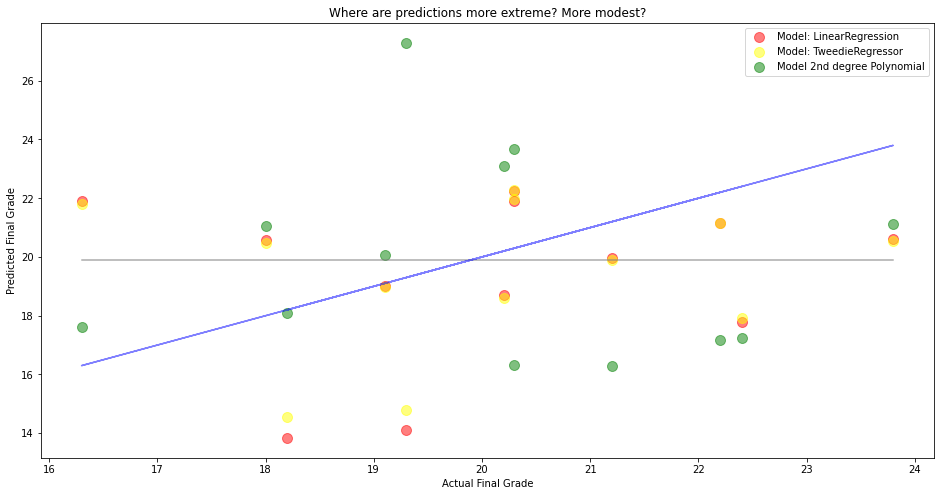

In [72]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.Infant_Mortality, y_validate.IM_pred_mean, alpha=.5, color="gray", label='_nolegend_')
#plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.Infant_Mortality, y_validate.Infant_Mortality, alpha=.5, color="blue", label='_nolegend_')
#plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.Infant_Mortality, y_validate.IM_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.Infant_Mortality, y_validate.IM_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.Infant_Mortality, y_validate.IM_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Predicted Final Grade")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

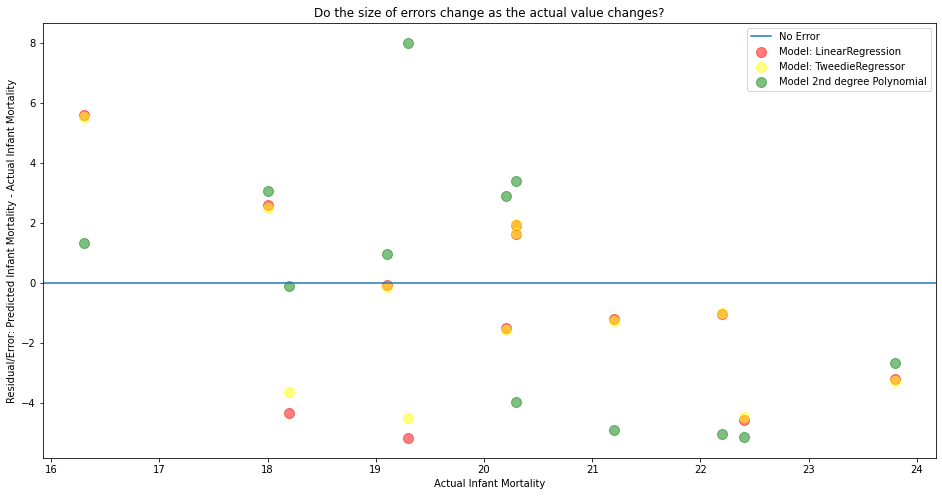

In [74]:
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.Infant_Mortality, y_validate.IM_pred_lm - y_validate.Infant_Mortality , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.Infant_Mortality, y_validate.IM_pred_glm - y_validate.Infant_Mortality, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.Infant_Mortality, y_validate.IM_pred_lm2 - y_validate.Infant_Mortality, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Infant Mortality")
plt.ylabel("Residual/Error: Predicted Infant Mortality - Actual Infant Mortality")
plt.title("Do the size of errors change as the actual value changes?")
#plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
#plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


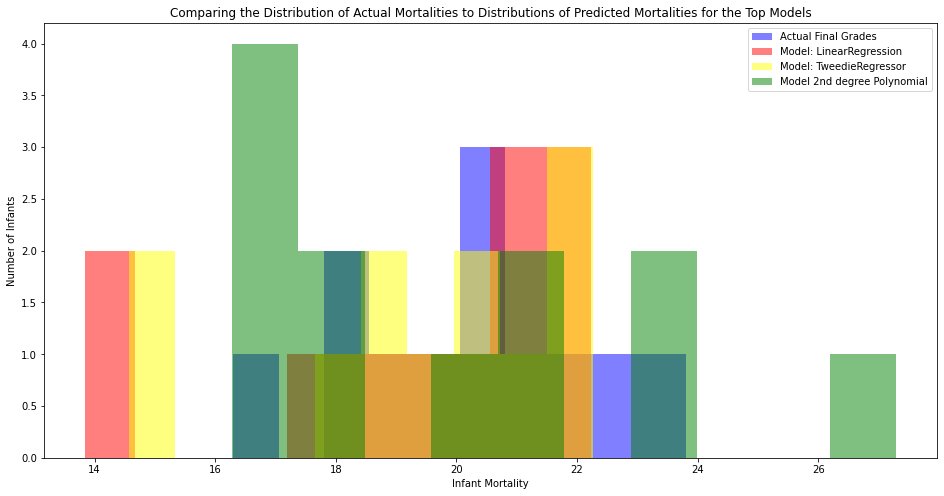

In [75]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.Infant_Mortality, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(y_validate.IM_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.IM_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.IM_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Infant Mortality")
plt.ylabel("Number of Infants")
plt.title("Comparing the Distribution of Actual Mortalities to Distributions of Predicted Mortalities for the Top Models")
plt.legend()
plt.show()

## Model Selection & Out-of-Sample Evaluation


Model selected: lm2 (using PolynomialRegression)

In [79]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['IM_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.Infant_Mortality, y_test.IM_pred_lm2)**(1/2)

print("RMSE for OLS Model using PolynomialRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using PolynomialRegression
Out-of-Sample Performance:  6.722287377033738
